In [2]:
import json
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # matplotlib is not installed automatically
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [5]:
network_name = 'California'

input_path = r"..\1_data"
appeears_path = r"APPEEARS_subsetting"
SMAPL3_path = r"SPL3SMP_E"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
MODIS_path = r"MOD15A2H"
PET_path = r"PET"

## Read and process data

### Request json

In [7]:
file_path = os.path.join(input_path, appeears_path, network_name, f'{network_name}-request.json')
with open(file_path, 'r') as infile:
    request_content = json.load(infile)

coordinates = request_content['params']['coordinates']

coordinate = 0
target_lat = coordinates[coordinate]['latitude']
target_lon = coordinates[coordinate]['longitude']
target_station = coordinates[coordinate]['category']
print(f'Currently processing station: {target_station}')

output_path = os.path.join(r".\3_data_out", target_station)
if not os.path.exists(output_path):
    os.makedirs(output_path)

Currently processing station: Central_valley


### SMAP L3

In [8]:
file_path = os.path.join(input_path, appeears_path, network_name, f'{network_name}-SPL3SMP-E-005-results.csv')
SMAPL3_pt_sample = pd.read_csv(file_path)
SMAPL3_pt_sample = SMAPL3_pt_sample[(SMAPL3_pt_sample['Latitude'] == target_lat) & (SMAPL3_pt_sample['Longitude'] == target_lon)].copy()

df_ts_smap_am = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag']].copy()
df_ts_smap_am['Date'] = pd.to_datetime(df_ts_smap_am['Date'])
df_ts_smap_am.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_am[(df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)].index
df_ts_smap_am.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_am_daily = df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture'].resample('D', axis=0).mean()

df_ts_smap_pm = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm']].copy()
df_ts_smap_pm['Date'] = pd.to_datetime(df_ts_smap_pm['Date'])
df_ts_smap_pm.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_pm[(df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)].index
df_ts_smap_pm.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_pm_daily = df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'].resample('D', axis=0).mean()

df_ts_sync = pd.merge(df_ts_smap_am_daily, df_ts_smap_pm_daily, how='inner', left_index=True, right_index=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync[['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync['soil_moisture_smapL3'].resample('D', axis=0).mean()

### SMAPL4

In [20]:
file_path = os.path.join(input_path, appeears_path, network_name, f'{network_name}-SPL4SMGP-006-results.csv')
SMAPL4_pt_sample = pd.read_csv(file_path)
SMAPL4_pt_sample = SMAPL4_pt_sample[(SMAPL4_pt_sample['Latitude'] == target_lat) & (SMAPL4_pt_sample['Longitude'] == target_lon)].copy()
# print(SMAPL4_pt_sample.columns)

# SMAPL4_pt_sample[['SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0', 
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_1',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_2',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_3',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_4',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_5',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_6',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_7']].plot()

# ? Where is data converted to daily from hourly? 

df_ts_smap_precip = SMAPL4_pt_sample[['Date', 'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0']].copy()
df_ts_smap_precip = df_ts_smap_precip.rename({'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0': 'precip'}, axis='columns')
df_ts_smap_precip['Date'] = pd.to_datetime(df_ts_smap_precip['Date'])
df_ts_smap_precip.set_index('Date', inplace=True)
df_ts_smap_precip

,precip
Date,
2015-03-31,0.000000
2015-04-01,0.000000
2015-04-02,0.000000
2015-04-03,0.000000
2015-04-04,0.000000
...,...
2022-03-26,0.000000
2022-03-27,0.000000
2022-03-28,0.000000


In [ ]:
df_ts_sync = pd.merge(df_ts_sync, df_ts_smap_precip, how='inner', left_index=True, right_index=True)

noprecip = df_ts_smap_precip['precip'] < 0.00002
df_ts_sync['noprecip'] = noprecip

df_ts_sync.head()

### PET

Get the point-sampled PET data beforehand by running '0_code\singerPET_create_datarods_v3.py'

In [17]:
file_path = os.path.join(input_path, PET_path, target_station)
file_list = os.listdir(file_path)

print(file_list)
PET = pd.read_csv(os.path.join(file_path, file_list[0]), header=None)
day_num = PET.index.to_numpy()
year = file_list[0][-8:-4]
PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
PET.set_index('Date', inplace=True)

for i, file in enumerate(file_list):
    PET = pd.read_csv(os.path.join(file_path, file), header=None)
    year = file[-8:-4]
    PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
    PET.set_index('Date', inplace=True)
    if i==0:
        ds_PET = PET
    else:
        ds_PET = pd.concat([ds_PET, PET])
ds_PET = ds_PET.sort_index()
ds_PET = ds_PET.rename(columns = {0:'PET'})
ds_PET

['dPET_2015.txt', 'dPET_2016.txt', 'dPET_2017.txt', 'dPET_2018.txt', 'dPET_2019.txt', 'dPET_2020.txt', 'dPET_2021.txt']


,PET
Date,
2015-01-01,1.20622
2015-01-02,1.32404
2015-01-03,1.30129
2015-01-04,1.39553
2015-01-05,1.54896
...,...
2021-12-27,0.65487
2021-12-28,0.54032
2021-12-29,0.35751


In [23]:
ds_synced = pd.merge(df_ts_sync[['soil_moisture_smapL3', 'precip']], ds_PET, how='inner', left_index=True, right_index=True)
ds_synced = ds_synced.rename({'soil_moisture_smapL3': 'soil_moisture_daily'}, axis='columns')
ds_synced

,soil_moisture_daily,precip,PET
Date,,,
2015-04-03,0.080593,0.000000e+00,4.26590
2015-04-04,0.052842,0.000000e+00,4.10291
2015-04-05,0.073338,0.000000e+00,3.96359
2015-04-06,0.082093,0.000000e+00,3.65490
2015-04-07,0.050903,0.000000e+00,2.23610
...,...,...,...
2021-12-27,NaN,0.000000e+00,0.65487
2021-12-28,NaN,5.510000e-05,0.54032
2021-12-29,NaN,8.000000e-07,0.35751


## Calculate dSdt

In [21]:
# Thresholds
lower_quantile_thresh = 0.25
upper_quantile_thresh = 0.75
precip_thresh = 0.00002

In [25]:
precip_mask = ds_synced['precip'].where(ds_synced['precip'] < precip_thresh)
no_sm_record_but_precip_present = ds_synced['precip'].where((precip_mask.isnull()) & (ds_synced['soil_moisture_daily'].isnull()))
ds_synced['sm_for_dS_calc'] = ds_synced['soil_moisture_daily'].where(no_sm_record_but_precip_present.isnull(), 9999)

In [27]:
# Calculate dS
ds_synced['dS'] = ds_synced['sm_for_dS_calc'].bfill(limit=5).diff().where(ds_synced['sm_for_dS_calc'].notnull().shift(periods=+1))

# Drop the dS where  (precipitation is present) && (soil moisture record does not exist)
ds_synced['dS'] = ds_synced['dS'].where((ds_synced['dS'] > -1) & (ds_synced['dS'] < 1))

# Calculate dt
non_nulls = ds_synced['sm_for_dS_calc'].isnull().cumsum()
nan_length = non_nulls.where(ds_synced['sm_for_dS_calc'].notnull()).bfill()+1 - non_nulls +1
ds_synced['dt'] = nan_length.where(ds_synced['sm_for_dS_calc'].isnull()).fillna(1)

# Calculate dS/dt
ds_synced['dSdt'] = ds_synced['dS']/ds_synced['dt']
ds_synced['dSdt'] = ds_synced['dSdt'].shift(periods=-1)


In [28]:
# Mask where precipitation is on the day 1 of soil moisture measruement
ds_synced['dSdt'] = ds_synced['dSdt'].where(precip_mask.notnull())

In [30]:
ds_synced.head()

,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt
Date,,,,,,,
2015-04-03,0.080593,0.0,4.26590,0.080593,NaN,1.0,-0.027751
2015-04-04,0.052842,0.0,4.10291,0.052842,-0.027751,1.0,0.020496
2015-04-05,0.073338,0.0,3.96359,0.073338,0.020496,1.0,0.008755
2015-04-06,0.082093,0.0,3.65490,0.082093,0.008755,1.0,-0.031190
2015-04-07,0.050903,0.0,2.23610,0.050903,-0.031190,1.0,0.142930


## Plot

(17106.0, 17165.0)

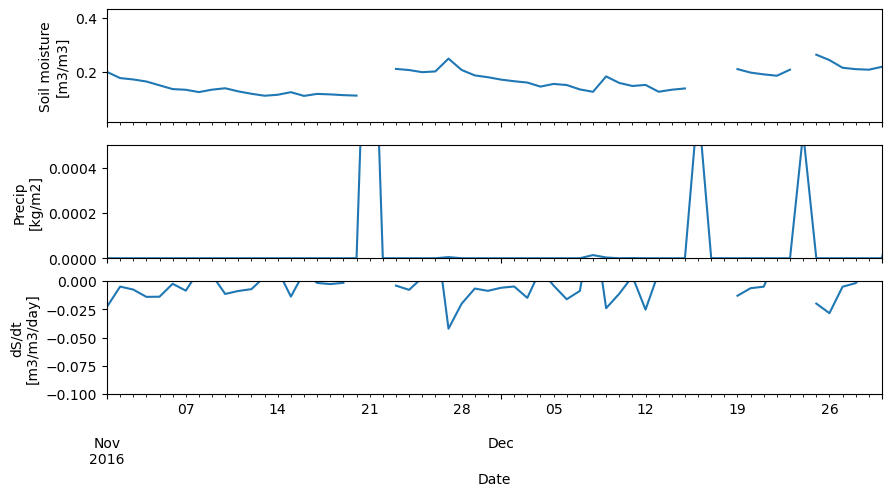

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
ds_synced['soil_moisture_daily'].plot(ax=ax1)
ax1.set_ylabel('Soil moisture\n[m3/m3]')
ds_synced['precip'].plot(ax=ax2)
ax2.set_ylim([0, 0.0005])
ax2.set_ylabel('Precip\n[kg/m2]')
ds_synced['dSdt'].plot(ax=ax3)
ax3.set_ylabel('dS/dt\n[m3/m3/day]')
ax3.set_ylim([-0.1, 0])
ax1.set_xlim([datetime(2016, 11, 1), datetime(2016, 12, 30)])

Text(0, 0.5, 'dS/dt')

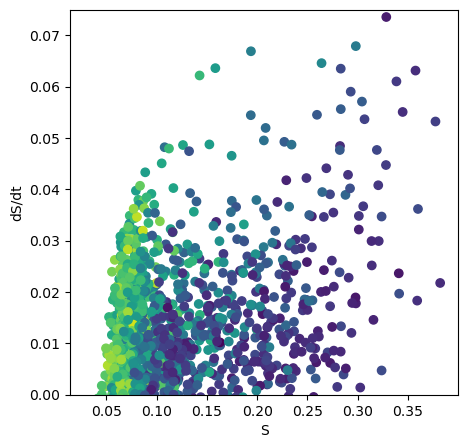

In [52]:
x1 = ds_synced.soil_moisture_daily.values
y1 = ds_synced.dSdt.values * -1
z1 = ds_synced.PET.values

fig, (ax3) = plt.subplots(1, 1, figsize=(5, 5))
high_diff_plot = ax3.scatter(x1, y1, c=z1, cmap='viridis')
ax3.set_ylim([0,0.075])
ax3.set_xlabel('S')
ax3.set_ylabel('dS/dt')

## Investigate on consective dSdt

In [54]:
ds_synced['dSdt']

Date
2015-04-03   -0.027751
2015-04-04    0.020496
2015-04-05    0.008755
2015-04-06   -0.031190
2015-04-07    0.142930
                ...   
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
Name: dSdt, Length: 2465, dtype: float64

In [55]:
neg_mask = ds_synced['dSdt'] < 0
neg_mask

Date
2015-04-03     True
2015-04-04    False
2015-04-05    False
2015-04-06     True
2015-04-07    False
              ...  
2021-12-27    False
2021-12-28    False
2021-12-29    False
2021-12-30    False
2021-12-31    False
Name: dSdt, Length: 2465, dtype: bool

In [56]:
consec_neg_mask = neg_mask.ne(neg_mask.shift())
consec_neg_mask

Date
2015-04-03     True
2015-04-04     True
2015-04-05    False
2015-04-06     True
2015-04-07     True
              ...  
2021-12-27    False
2021-12-28    False
2021-12-29    False
2021-12-30    False
2021-12-31    False
Name: dSdt, Length: 2465, dtype: bool

In [65]:
event_num = consec_neg_mask.cumsum().where(neg_mask) 
event_num

Date
2015-04-03    1.0
2015-04-04    NaN
2015-04-05    NaN
2015-04-06    3.0
2015-04-07    NaN
             ... 
2021-12-27    NaN
2021-12-28    NaN
2021-12-29    NaN
2021-12-30    NaN
2021-12-31    NaN
Name: dSdt, Length: 2465, dtype: float64

In [66]:
ds_synced['event_num'] = event_num

In [81]:
grouped_dSdt = ds_synced.groupby('event_num')['dSdt'].apply(list)
grouped_PET = ds_synced.groupby('event_num')['PET'].apply(list)
grouped_sm = ds_synced.groupby('event_num')['soil_moisture_daily'].apply(list)
grouped_precip = ds_synced.groupby('event_num')['precip'].apply(list)
ds_synced['time'] = ds_synced.index
grouped_time = ds_synced.groupby('event_num')['time'].apply(list)

In [83]:
grouped_dSdt = pd.DataFrame(grouped_dSdt)

In [84]:
grouped_datasets = grouped_dSdt.merge(grouped_PET, on='event_num', how='outer') \
               .merge(grouped_sm, on='event_num', how='outer') \
               .merge(grouped_precip, on='event_num', how='outer') \
               .merge(grouped_time, on='event_num', how='outer')

In [85]:
grouped_datasets.head()

,dSdt,PET,soil_moisture_daily,precip,time
event_num,,,,,
1.0,[-0.027751399999999996],[4.2659],[0.080593],[0.0],[2015-04-03 00:00:00]
3.0,[-0.031189800000000004],[3.6549],[0.0820931],[0.0],[2015-04-06 00:00:00]
5.0,"[-0.0669091, -0.0217112, -0.004835800000000001...","[3.47952, 2.94221, 3.96109, 4.97817]","[0.1938336, 0.1269245, 0.1052133, 0.1003775]","[0.0, 0.0, 0.0, 0.0]","[2015-04-08 00:00:00, 2015-04-09 00:00:00, 201..."
7.0,[-0.037960999999999995],[5.18541],[0.0817556],[0.0],[2015-04-14 00:00:00]
9.0,"[-0.019769299999999997, -0.0013203999999999994]","[4.96349, 4.90596]","[0.078025, 0.0582557]","[0.0, 0.0]","[2015-04-16 00:00:00, 2015-04-17 00:00:00]"


In [89]:
grouped_datasets['length'] = grouped_datasets['dSdt'].apply(len)

<Axes: >

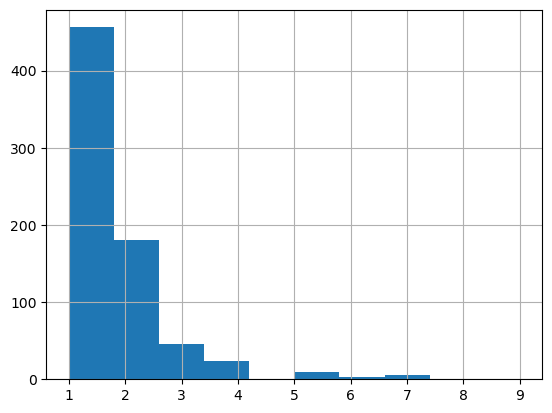

In [95]:
grouped_datasets['length'].hist()

In [102]:
exploded_df = grouped_datasets.explode(['dSdt', 'PET', 'soil_moisture_daily', 'precip', 'time'])
exploded_df

,dSdt,PET,soil_moisture_daily,precip,time,length
event_num,,,,,,
1.0,-0.027751,4.2659,0.080593,0.0,2015-04-03,1
3.0,-0.03119,3.6549,0.082093,0.0,2015-04-06,1
5.0,-0.066909,3.47952,0.193834,0.0,2015-04-08,4
5.0,-0.021711,2.94221,0.126924,0.0,2015-04-09,4
5.0,-0.004836,3.96109,0.105213,0.0,2015-04-10,4
...,...,...,...,...,...,...
1447.0,-0.004364,1.13105,0.115909,0.0,2021-12-08,1
1449.0,-0.011478,0.94926,0.206991,0.0,2021-12-10,4
1449.0,-0.023325,1.04563,0.195512,0.0,2021-12-11,4


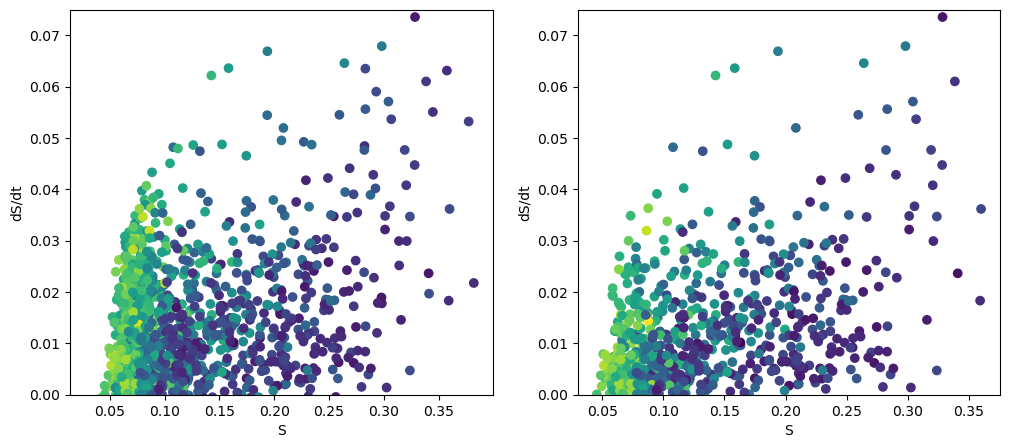

In [110]:
x1 = ds_synced.soil_moisture_daily.values
y1 = ds_synced.dSdt.values * -1
z1 = ds_synced.PET.values

length_thresh = 2

x2 = exploded_df.soil_moisture_daily[exploded_df['length']>=length_thresh].values
y2 = exploded_df.dSdt[exploded_df['length']>=length_thresh].values * -1
z2 = exploded_df.PET[exploded_df['length']>=length_thresh].values

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
high_diff_plot = ax3.scatter(x1, y1, c=z1, cmap='viridis')
ax3.set_ylim([0,0.075])
ax3.set_xlabel('S')
ax3.set_ylabel('dS/dt')

restricted_plot = ax4.scatter(x2, y2, c=z2, cmap='viridis')
ax4.set_ylim([0,0.075])
ax4.set_xlabel('S')
ax4.set_ylabel('dS/dt')

restricted_plot.colorbar




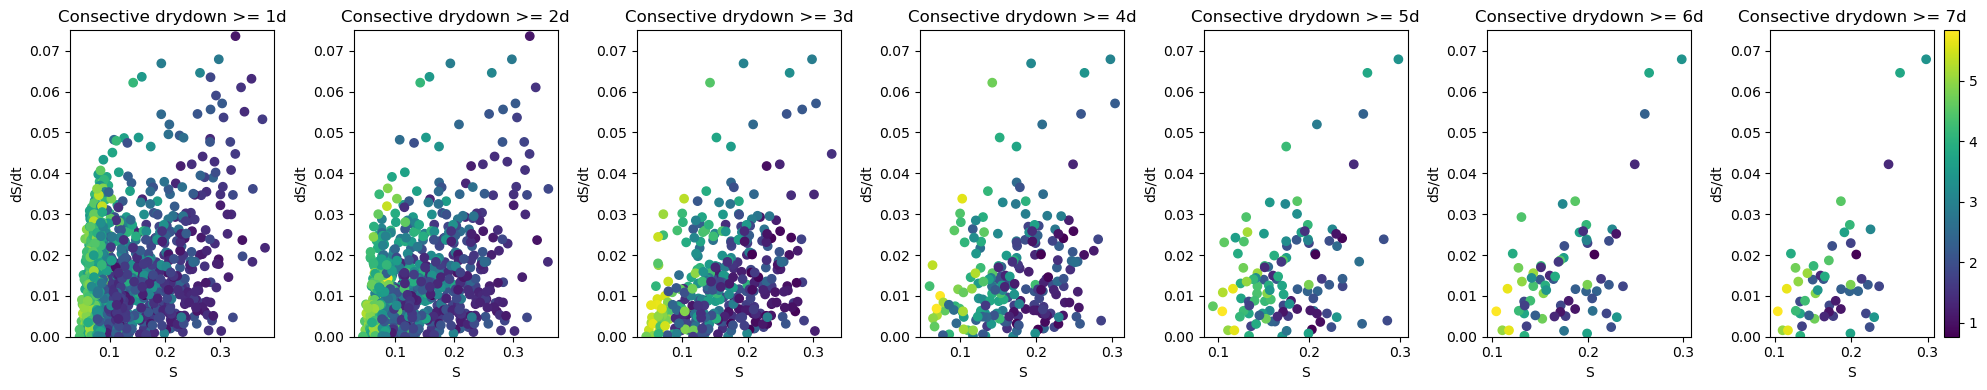

In [121]:
# create subplots for different values of length_thresh
fig, axs = plt.subplots(1, 7, figsize=(20, 4))

for i in range(7):
    length_thresh = i + 1

    x = exploded_df.soil_moisture_daily[exploded_df['length']>=length_thresh].values
    y = exploded_df.dSdt[exploded_df['length']>=length_thresh].values * -1
    z = exploded_df.PET[exploded_df['length']>=length_thresh].values
    
    sc = axs[i].scatter(x, y, c=z, cmap='viridis')
    axs[i].set_ylim([0, 0.075])
    axs[i].set_xlabel('S')
    axs[i].set_ylabel('dS/dt')
    axs[i].set_title(f'Consective drydown >= {length_thresh}d')


fig.colorbar(sc, ax=axs[6])

plt.tight_layout()
plt.show()
